##  Install the EVA4 packages, hosted @ github

In [10]:
!pip install git+https://git@github.com/ojhajayant/eva.git

  Cloning https://****@github.com/ojhajayant/eva.git to c:\users\ojhaj\appdata\local\temp\pip-req-build-gihswzx6
  Created wheel for eva: filename=eva-0.0.0-py3-none-any.whl size=35626 sha256=c90ecd0a18faefebd9c63f8218a16dd27460e080e097b99a20d564b3a50e5a63
  Stored in directory: C:\Users\ojhaj\AppData\Local\Temp\pip-ephem-wheel-cache-j84s8_se\wheels\10\eb\41\b45f3a92716bbd015028946c2b4873f4622041a4db30191fb6
Successfully built eva
  Attempting uninstall: eva
    Found existing installation: eva 0.0.1
    Uninstalling eva-0.0.1:
      Successfully uninstalled eva-0.0.1


  Running command git clone -q 'https://****@github.com/ojhajayant/eva.git' 'C:\Users\ojhaj\AppData\Local\Temp\pip-req-build-gihswzx6'


# Import Libraries

In [1]:
from __future__ import print_function

import os
import sys
import warnings

import numpy as np
import torch
import torch.optim as optim
from torchsummary import summary

from week7.modular import cfg
from week7.modular.models import resnet18, s5_s6_custom_model_mnist, s7_custom_model_cifar10, QuizDNN
from week7.modular import preprocess
from week7.modular import preprocess_albumentations
from week7.modular import test
from week7.modular import train
from week7.modular import utils

sys.path.append('./')
global args
args = cfg.args
args.IPYNB_ENV = True
#Use albumentations lib for image-augmentation
#if below flag is false, usual torchvision 
#transforms are applied.
args.use_albumentations = True

### Save the config file, with all default/provided/required configuration

In [2]:
print("The config used for this run are being saved @ {}".format(os.path.join(args.prefix, 'config_params.txt')))
utils.write(vars(args), os.path.join(args.prefix, 'config_params.txt'))

The config used for this run are being saved @ data\config_params.txt


### Calculate mean & std for Normalization

In [3]:
args.dataset = 'CIFAR10'
mean, std = preprocess.get_dataset_mean_std()
mean_tuple = (mean[0], mean[1], mean[2])
std_tuple = (std[0], std[1], std[2])

Files already downloaded and verified
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


###  Dataloader Arguments & Test/Train Dataloaders

In [4]:
if np.ndim(mean) ==0:
    if args.use_albumentations:
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data((mean,), (std,))
    else:
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data_albumentations((mean,), (std,))    
else:
    if args.use_albumentations:
        print("Using albumentation lib for image-augmentation & other transforms")
        train_dataset, test_dataset, train_loader, test_loader = \
            preprocess_albumentations.preprocess_data_albumentations(mean_tuple, std_tuple)
    else:
        print("Using torchvison for image-augmentation & other transforms")
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data(mean_tuple, std_tuple)

Using albumentation lib for image-augmentation & other transforms
************
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


### Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Stats from Train Data]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
[Stats from Test Data]
 - Numpy Shape: (10000, 32, 32, 3)
 - Tensor Shape: torch.Size([10000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])
torch.Size([64])
Saving plot for a sample to ascertain RF required for edges & gradient D:\PG-ML\eva4\week9\./data/data_stats.png


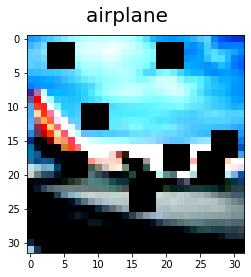

In [15]:
preprocess.get_data_stats(train_dataset, test_dataset, train_loader)

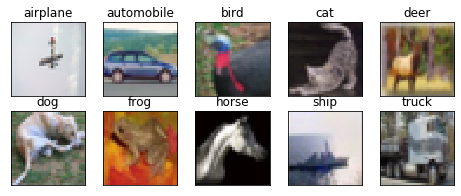

In [6]:
utils.plot_train_samples(train_loader)

### Using L1-regularization here 
(l1_weight = 0.000025, started out reusing some older assignment values, but works OK here too)

In [7]:
L1 = args.L1   
print("L1:", L1)
L2 = args.L2   
print("L2:", L2)

L1: True
L2: False


### detect the device being run on

In [5]:
device = torch.device("cuda" if args.cuda else "cpu")
print(device)

cuda


### Get the model loaded with summary

In [9]:
model = resnet18.ResNet18().to(device)
if args.dataset == 'CIFAR10':
    summary(model, input_size=(3, 32, 32))
elif args.dataset == 'MNIST':
    summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Training and Testing

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Model training starts on CIFAR10 dataset
EPOCH: 1


Loss=1.1938164234161377 Batch_id=781 Accuracy=49.78: 100%|███████████████████████████| 782/782 [02:01<00:00,  6.42it/s]



Test set: Average loss: 1.0116, Accuracy: 6326/10000 (63.26%)

validation-accuracy improved from 0 to 63.26, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-1_L1-1_L2-0_val_acc-63.26.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 2


Loss=1.1422334909439087 Batch_id=781 Accuracy=68.65: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.33it/s]



Test set: Average loss: 0.8019, Accuracy: 7297/10000 (72.97%)

validation-accuracy improved from 63.26 to 72.97, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-2_L1-1_L2-0_val_acc-72.97.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 3


Loss=0.8033443689346313 Batch_id=781 Accuracy=76.36: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.34it/s]



Test set: Average loss: 0.6432, Accuracy: 7740/10000 (77.40%)

validation-accuracy improved from 72.97 to 77.4, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-3_L1-1_L2-0_val_acc-77.4.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 4


Loss=0.4780978262424469 Batch_id=781 Accuracy=80.47: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.32it/s]



Test set: Average loss: 0.5809, Accuracy: 8055/10000 (80.55%)

validation-accuracy improved from 77.4 to 80.55, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-4_L1-1_L2-0_val_acc-80.55.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 5


Loss=0.44373440742492676 Batch_id=781 Accuracy=83.43: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.30it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7568, Accuracy: 7516/10000 (75.16%)

EPOCH: 6


Loss=0.4987477958202362 Batch_id=781 Accuracy=85.56: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.32it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6070, Accuracy: 7960/10000 (79.60%)

EPOCH: 7


Loss=0.4333514869213104 Batch_id=781 Accuracy=87.53: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.34it/s]



Test set: Average loss: 0.5947, Accuracy: 8124/10000 (81.24%)

validation-accuracy improved from 80.55 to 81.24, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-7_L1-1_L2-0_val_acc-81.24.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 8


Loss=0.7081902027130127 Batch_id=781 Accuracy=89.11: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.34it/s]



Test set: Average loss: 0.5526, Accuracy: 8277/10000 (82.77%)

validation-accuracy improved from 81.24 to 82.77, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-8_L1-1_L2-0_val_acc-82.77.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 9


Loss=0.6426583528518677 Batch_id=781 Accuracy=90.02: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.34it/s]



Test set: Average loss: 0.4893, Accuracy: 8533/10000 (85.33%)

validation-accuracy improved from 82.77 to 85.33, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-9_L1-1_L2-0_val_acc-85.33.h5
EPOCH: 10


Loss=0.1453838050365448 Batch_id=781 Accuracy=91.37: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.33it/s]



Test set: Average loss: 0.4644, Accuracy: 8548/10000 (85.48%)

validation-accuracy improved from 85.33 to 85.48, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-10_L1-1_L2-0_val_acc-85.48.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 11


Loss=0.09714078903198242 Batch_id=781 Accuracy=92.27: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.32it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5025, Accuracy: 8470/10000 (84.70%)

EPOCH: 12


Loss=0.39840278029441833 Batch_id=781 Accuracy=93.20: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.27it/s]



Test set: Average loss: 0.4585, Accuracy: 8597/10000 (85.97%)

validation-accuracy improved from 85.48 to 85.97, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-12_L1-1_L2-0_val_acc-85.97.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 13


Loss=0.5929864048957825 Batch_id=781 Accuracy=94.22: 100%|███████████████████████████| 782/782 [02:04<00:00,  6.28it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5487, Accuracy: 8429/10000 (84.29%)

EPOCH: 14


Loss=0.49649715423583984 Batch_id=781 Accuracy=94.54: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5354, Accuracy: 8492/10000 (84.92%)

EPOCH: 15


Loss=0.06074455380439758 Batch_id=781 Accuracy=95.28: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.30it/s]



Test set: Average loss: 0.4947, Accuracy: 8627/10000 (86.27%)

validation-accuracy improved from 85.97 to 86.27, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-15_L1-1_L2-0_val_acc-86.27.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 16


Loss=0.11008298397064209 Batch_id=781 Accuracy=95.85: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.28it/s]



Test set: Average loss: 0.4586, Accuracy: 8698/10000 (86.98%)

validation-accuracy improved from 86.27 to 86.98, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-16_L1-1_L2-0_val_acc-86.98.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 17


Loss=0.16396388411521912 Batch_id=781 Accuracy=96.25: 100%|██████████████████████████| 782/782 [02:05<00:00,  6.23it/s]



Test set: Average loss: 0.4785, Accuracy: 8745/10000 (87.45%)

validation-accuracy improved from 86.98 to 87.45, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-17_L1-1_L2-0_val_acc-87.45.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 18


Loss=0.062398552894592285 Batch_id=781 Accuracy=96.66: 100%|█████████████████████████| 782/782 [04:06<00:00,  3.17it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6023, Accuracy: 8491/10000 (84.91%)

EPOCH: 19


Loss=0.23561334609985352 Batch_id=781 Accuracy=96.85: 100%|██████████████████████████| 782/782 [02:08<00:00,  6.10it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5843, Accuracy: 8595/10000 (85.95%)

EPOCH: 20


Loss=0.016510009765625 Batch_id=781 Accuracy=97.15: 100%|████████████████████████████| 782/782 [02:11<00:00,  5.95it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5118, Accuracy: 8743/10000 (87.43%)

EPOCH: 21


Loss=0.2903893291950226 Batch_id=781 Accuracy=97.44: 100%|███████████████████████████| 782/782 [02:12<00:00,  5.88it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5132, Accuracy: 8715/10000 (87.15%)

EPOCH: 22


Loss=0.10776406526565552 Batch_id=781 Accuracy=97.42: 100%|██████████████████████████| 782/782 [02:12<00:00,  5.91it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5427, Accuracy: 8692/10000 (86.92%)

EPOCH: 23


Loss=0.49669167399406433 Batch_id=781 Accuracy=97.87: 100%|██████████████████████████| 782/782 [02:13<00:00,  5.86it/s]



Test set: Average loss: 0.4945, Accuracy: 8763/10000 (87.63%)

validation-accuracy improved from 87.45 to 87.63, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-23_L1-1_L2-0_val_acc-87.63.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 24


Loss=0.3561747670173645 Batch_id=781 Accuracy=98.00: 100%|███████████████████████████| 782/782 [02:14<00:00,  5.84it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5139, Accuracy: 8728/10000 (87.28%)

EPOCH: 25


Loss=0.3673626780509949 Batch_id=781 Accuracy=98.02: 100%|███████████████████████████| 782/782 [02:15<00:00,  5.79it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5410, Accuracy: 8730/10000 (87.30%)

EPOCH: 26


Loss=0.04883211851119995 Batch_id=781 Accuracy=98.28: 100%|██████████████████████████| 782/782 [02:15<00:00,  5.77it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5601, Accuracy: 8701/10000 (87.01%)

EPOCH: 27


Loss=0.1723727136850357 Batch_id=781 Accuracy=98.34: 100%|███████████████████████████| 782/782 [02:13<00:00,  5.88it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5934, Accuracy: 8713/10000 (87.13%)

EPOCH: 28


Loss=0.19442865252494812 Batch_id=781 Accuracy=98.52: 100%|██████████████████████████| 782/782 [02:11<00:00,  5.95it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5288, Accuracy: 8755/10000 (87.55%)

EPOCH: 29


Loss=0.14253392815589905 Batch_id=781 Accuracy=98.36: 100%|██████████████████████████| 782/782 [02:13<00:00,  5.84it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5478, Accuracy: 8733/10000 (87.33%)

EPOCH: 30


Loss=0.019111186265945435 Batch_id=781 Accuracy=98.72: 100%|█████████████████████████| 782/782 [02:13<00:00,  5.85it/s]



Test set: Average loss: 0.5440, Accuracy: 8803/10000 (88.03%)

validation-accuracy improved from 87.63 to 88.03, saving model to D:\PG-ML\eva4\week9\./saved_models/CIFAR10_model_epoch-30_L1-1_L2-0_val_acc-88.03.h5


C:\Users\ojhaj\Anaconda3\lib\site-packages\week7\modular\utils.py:207: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


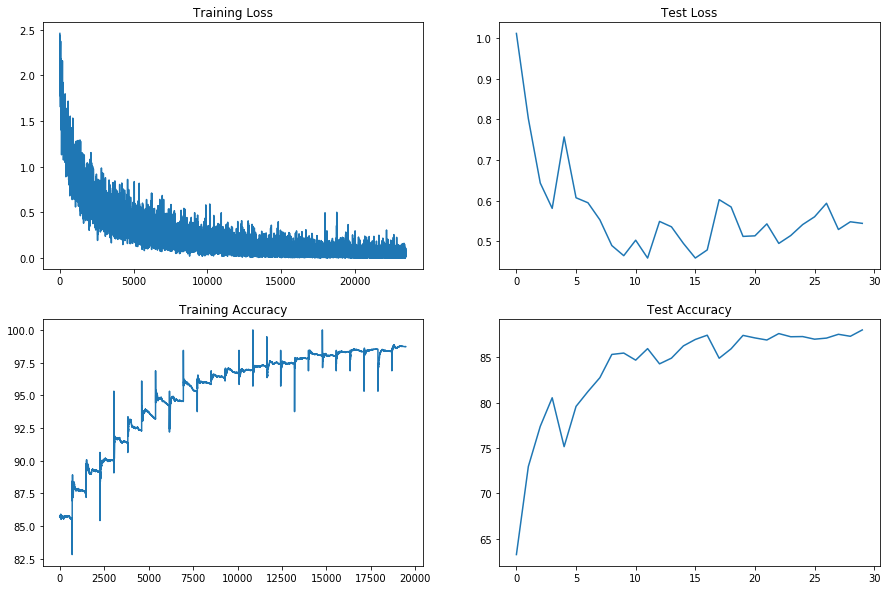

In [10]:
print("Model training starts on {} dataset".format(args.dataset))
# Enable L2-regularization with supplied value of weight decay, or keep it default-0
if L2:
    weight_decay = args.l2_weight_decay
else:
    weight_decay = 0
# lr = args.lr
#args.lr = 0.0006
args.lr = 0.008
lr = args.lr
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

#EPOCHS = args.epochs
args.epochs = 30
EPOCHS = args.epochs
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train.train(model, device, train_loader, optimizer, epoch)
    test.test(model, device, test_loader, optimizer, epoch)
utils.plot_acc_loss()

### model-prediction & mislabelled images

Model inference starts on CIFAR10  dataset
Loaded the best model: CIFAR10_model_epoch-30_L1-1_L2-0_val_acc-88.03.h5 from last training session
The confusion-matrix and classification-report for this model are:
[[904   8  26   8   9   3   2   5  29   6]
 [  6 962   2   4   3   2   1   0   5  15]
 [ 21   0 857  22  40  14  23  17   3   3]
 [ 18   2  45 732  44  96  26  24   9   4]
 [  9   1  37  20 879   8  20  22   3   1]
 [  5   3  25  96  30 797   4  38   1   1]
 [  5   1  28  21  10   7 921   2   2   3]
 [  5   2   4  12  21  14   0 937   3   2]
 [ 27   8   7   1   2   2   1   1 938  13]
 [ 19  74   6   4   3   1   4   3  10 876]]
              precision    recall  f1-score   support

    airplane       0.89      0.90      0.90      1000
  automobile       0.91      0.96      0.93      1000
        bird       0.83      0.86      0.84      1000
         cat       0.80      0.73      0.76      1000
        deer       0.84      0.88      0.86      1000
         dog       0.84      0.80 

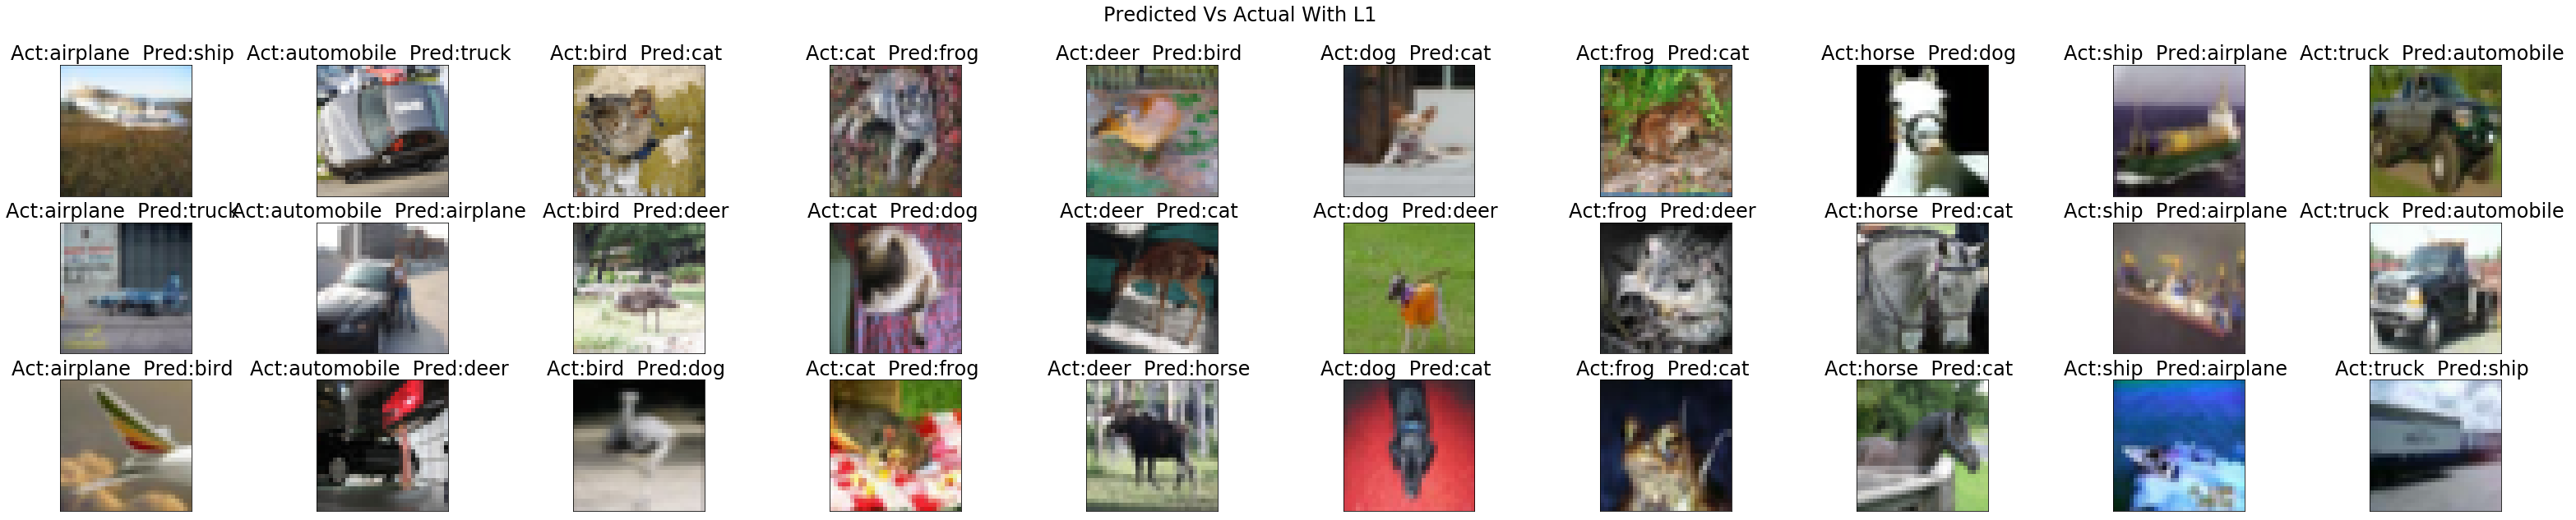

In [6]:
print("Model inference starts on {}  dataset".format(args.dataset))
#model_name = args.best_model
model_name = 'CIFAR10_model_epoch-30_L1-1_L2-0_val_acc-88.03.h5'
print("Loaded the best model: {} from last training session".format(model_name))
model = utils.load_model(resnet18.ResNet18(), device, model_name=model_name)
y_test = np.array(test_dataset.targets)
print("The confusion-matrix and classification-report for this model are:")
y_pred = utils.model_pred(model, device, y_test, test_dataset)
x_test = test_dataset.data
utils.display_mislabelled(model, device, x_test, y_test.reshape(-1, 1), y_pred, test_dataset, title_str='Predicted Vs Actual With L1')

### Model Layers for grad-cam

![caption](./model_stacking.png)

![caption](./model_layers.png)

### grad-cam displays "layer-2" (Resnet)

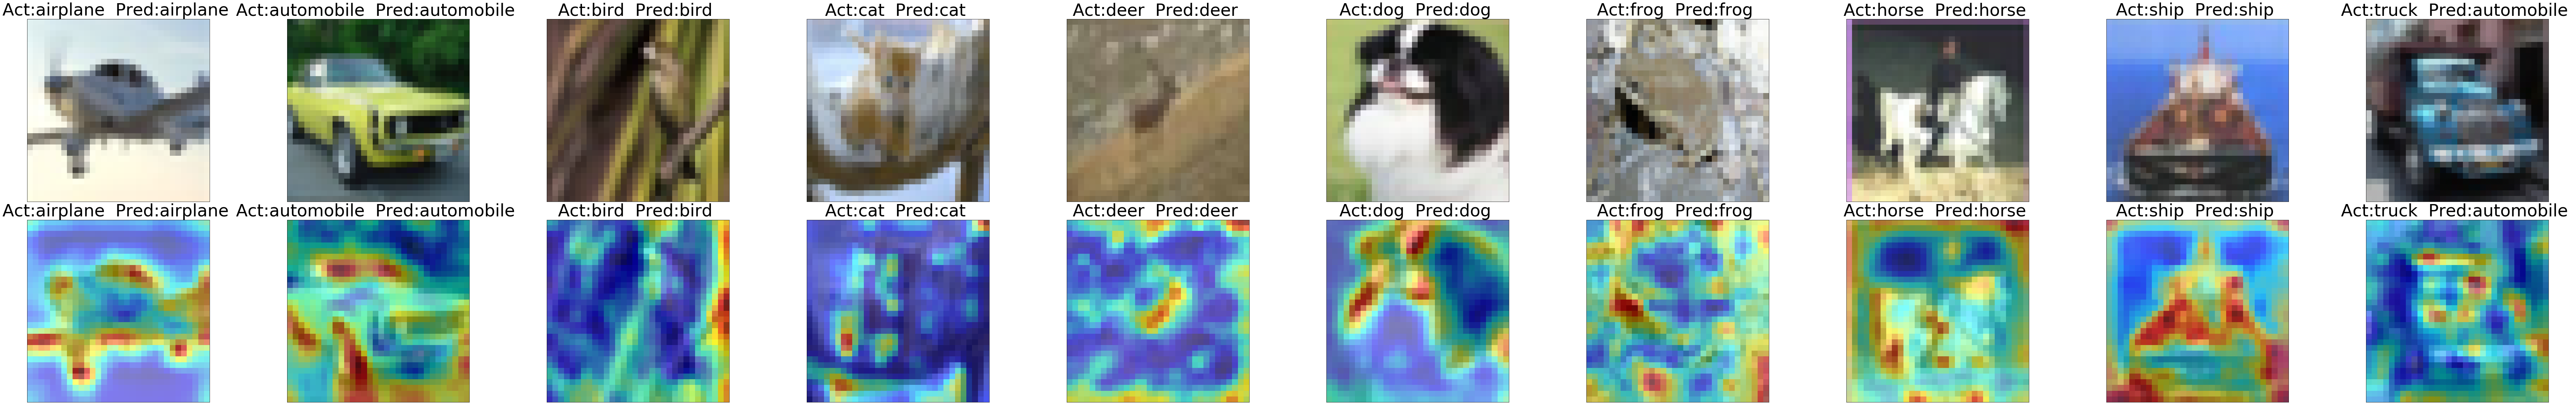

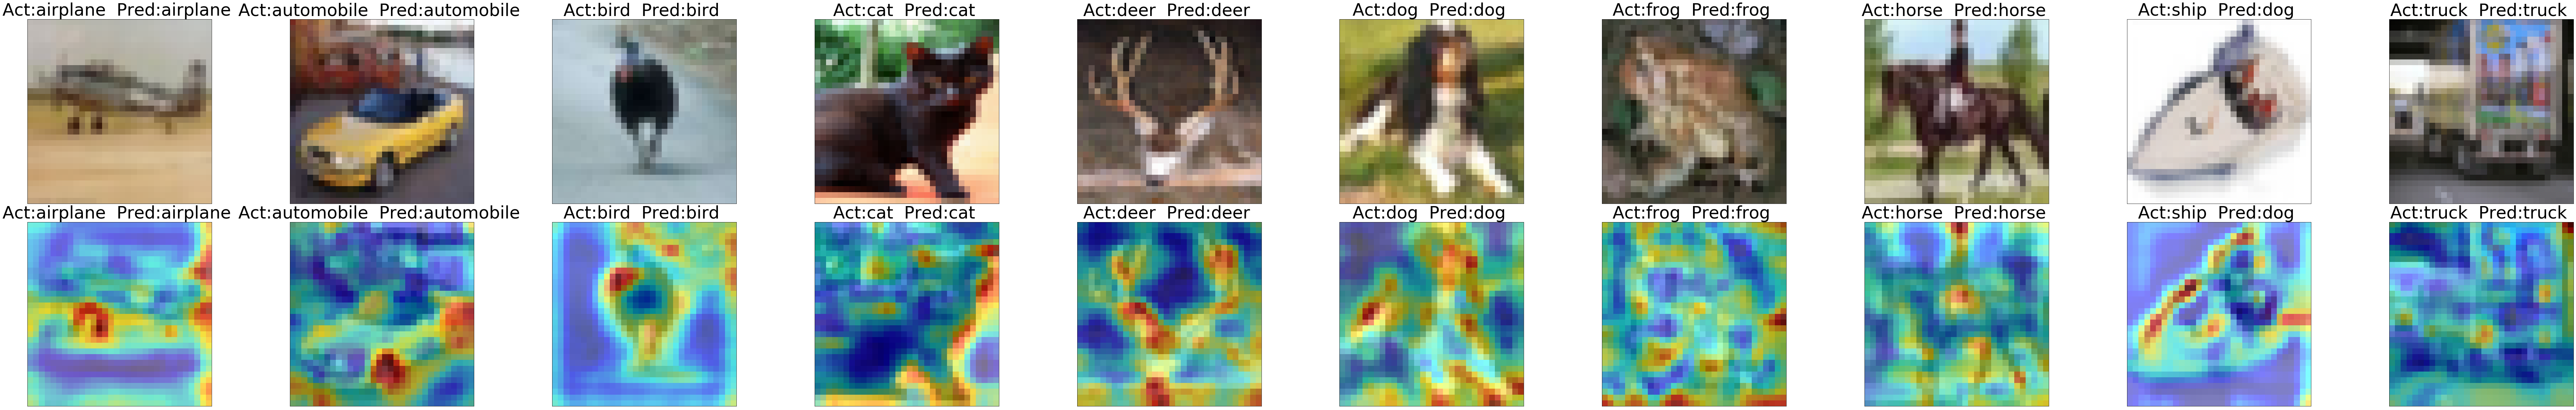

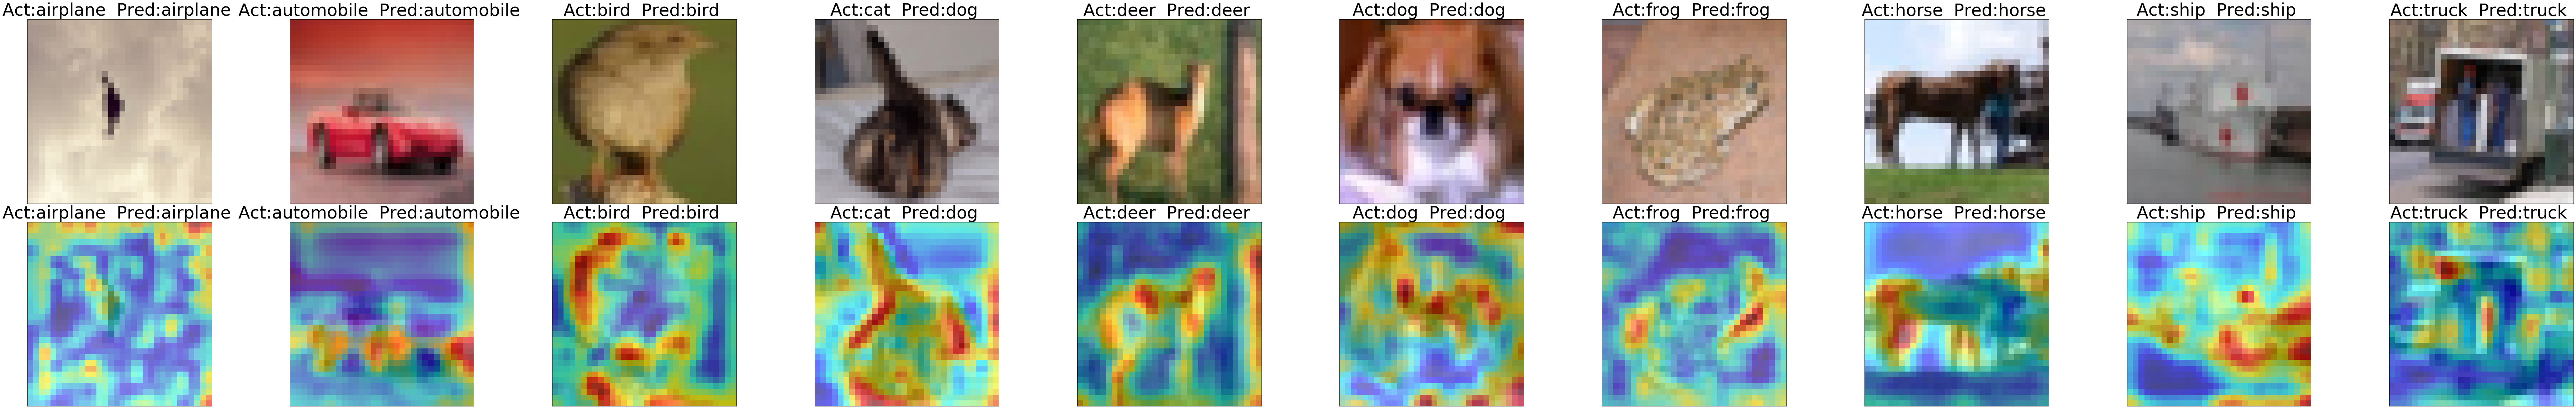

In [11]:
utils.show_gradcam(model, device, x_test, y_test, y_pred, test_dataset, mean_tuple, std_tuple, layer='layer2')

### grad-cam displays "layer-3" (Resnet)

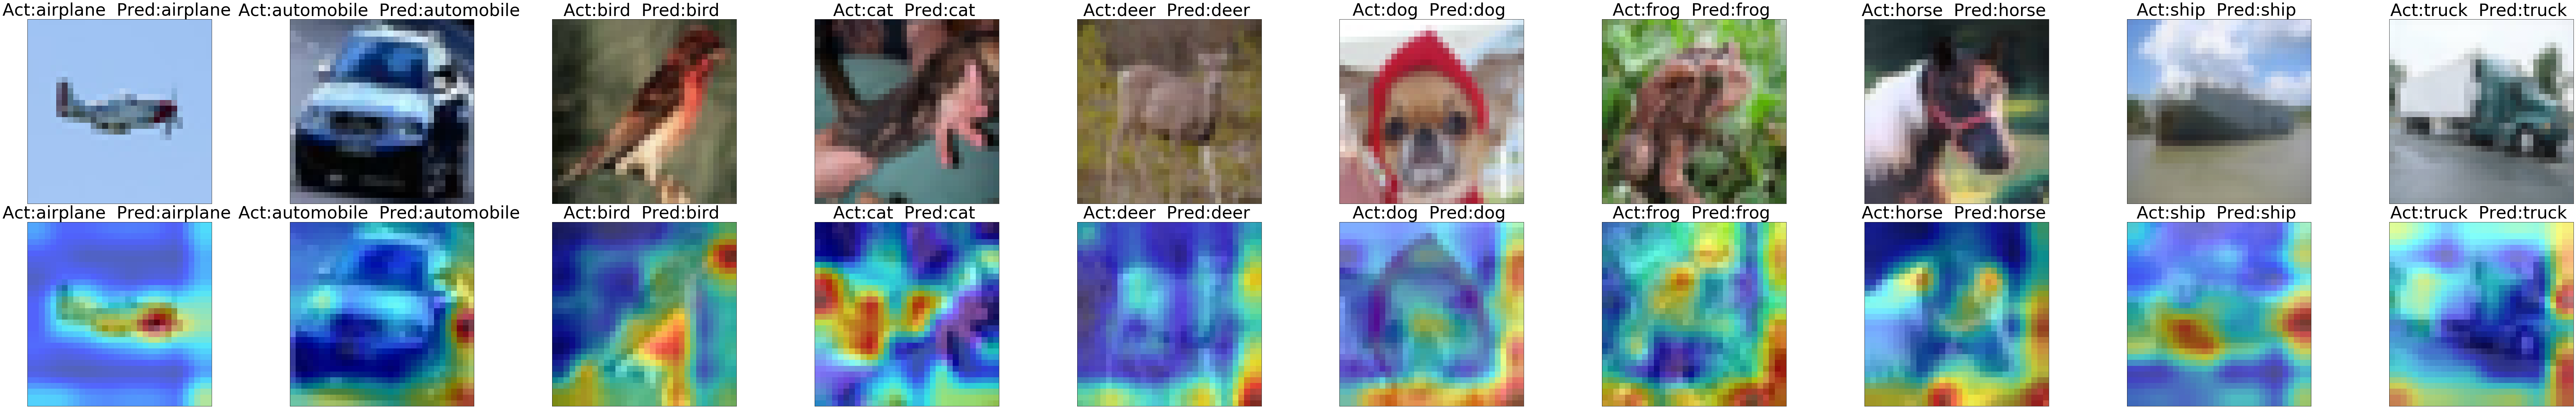

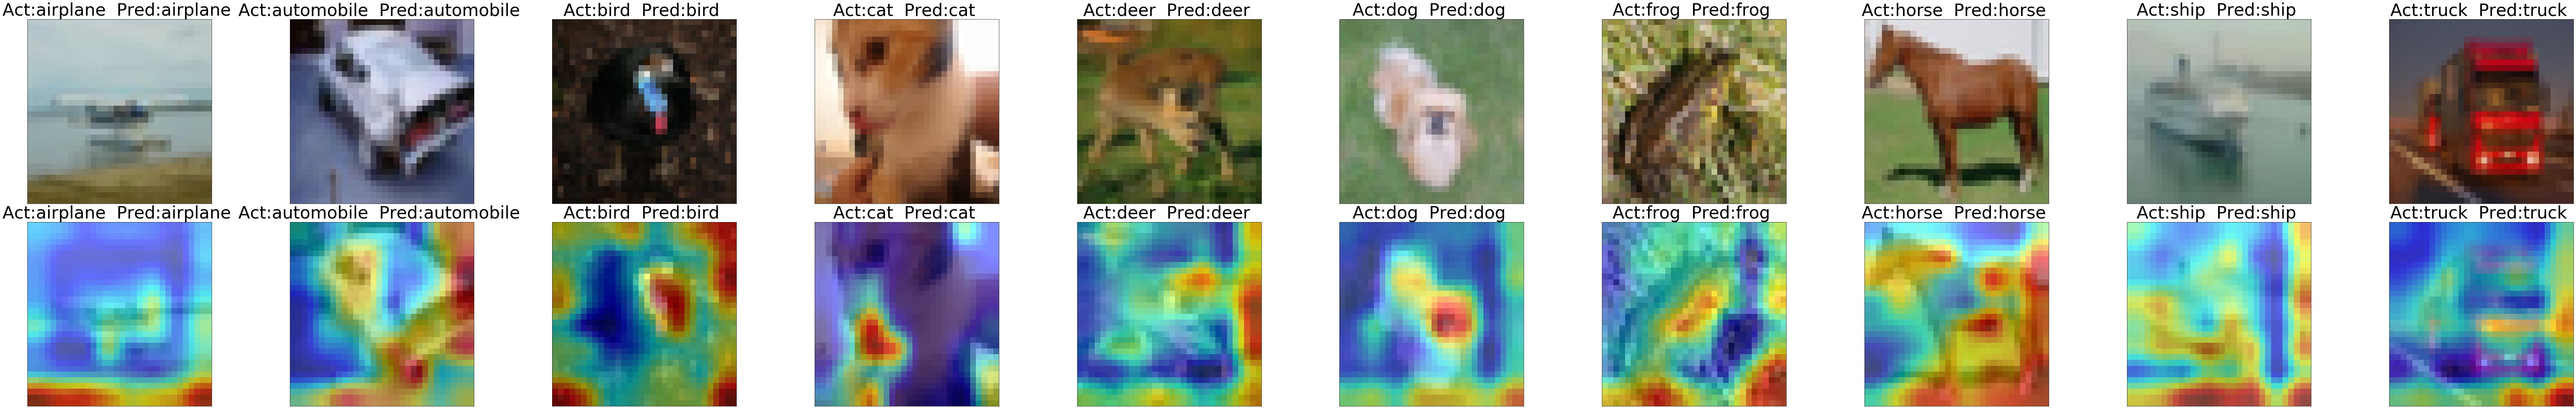

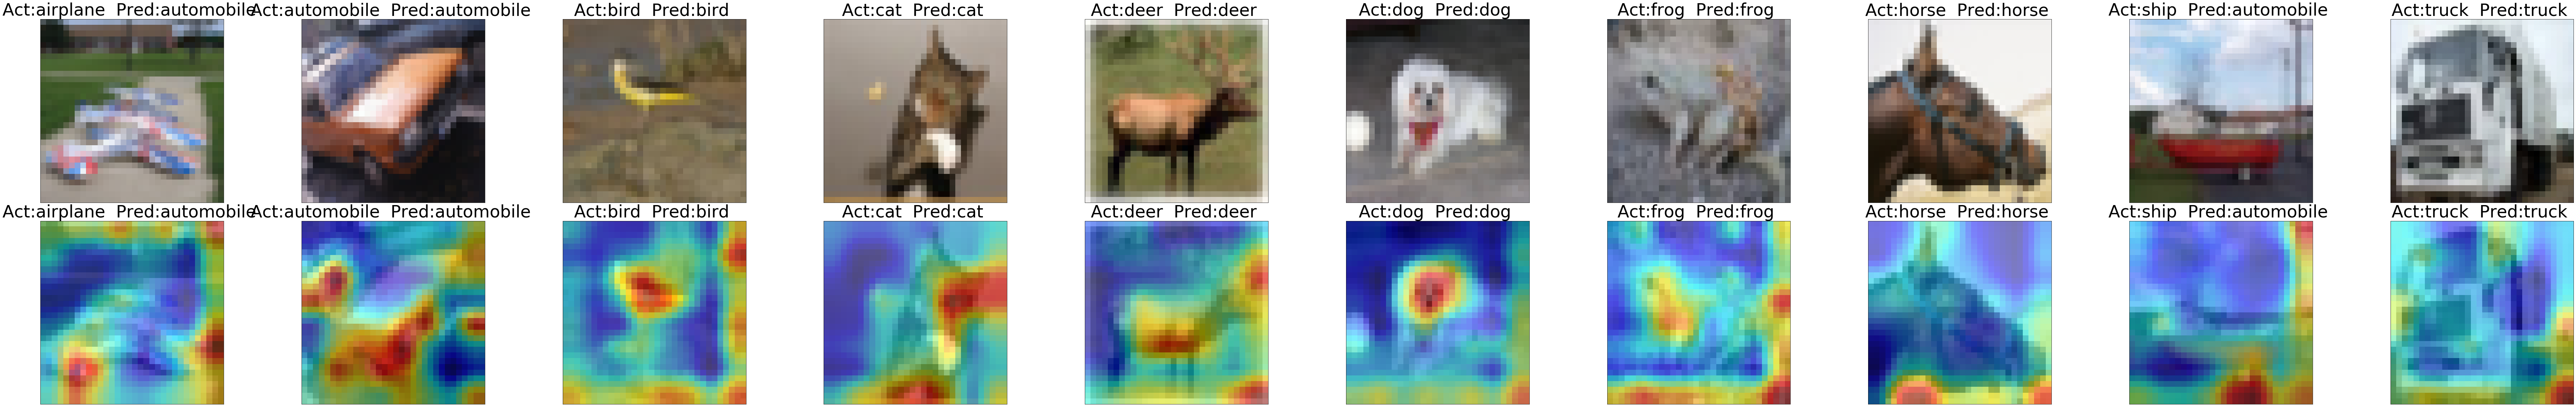

In [10]:
utils.show_gradcam(model, device, x_test, y_test, y_pred, test_dataset, mean_tuple, std_tuple, layer='layer3')